# Grundläggande analys och statistik

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.power import NormalIndPower, TTestIndPower

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["figure.dpi"] = 120
np.set_printoptions(precision=3)
pd.set_option("display.precision", 3)
plt.style.use("ggplot")

In [17]:
# Läsning av datasetet
df = pd.read_csv("../data/health_study_dataset.csv")

# Snabb kontroll
print(df.sample(5))
print()
print(df.info())
print()
print(df.describe())

      id  age sex  height  weight  systolic_bp  cholesterol smoker  disease
636  637   62   F   162.1    66.7        149.7         4.98    Yes        0
47    48   65   F   162.4    71.8        157.1         5.65    Yes        0
419  420   51   M   182.4    70.9        161.5         5.28     No        0
778  779   48   M   174.1    91.7        152.8         4.07     No        1
612  613   54   M   185.7    65.8        145.0         4.88    Yes        0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           800 non-null    int64  
 1   age          800 non-null    int64  
 2   sex          800 non-null    object 
 3   height       800 non-null    float64
 4   weight       800 non-null    float64
 5   systolic_bp  800 non-null    float64
 6   cholesterol  800 non-null    float64
 7   smoker       800 non-null    object 
 8   disease      8

In [18]:
# Städning
df.isna().sum()
df.duplicated().sum()

np.int64(0)

## Inledande observation

- Datasetet innehåller 800 rader, 9 kolumner. Inga saknade värden eller dubbletter

- Datatyper: 
    - Numeriska kontinuerliga: height, weight, systolic_bp, cholesterol
    - Numeriska diskreta: id, age, disease
    - Kategoriska: sex, smoker

- Range och fördelning:
    - Ålder varierar mellan 18 och 90 år, med ett medelvärde på cirka 49 år
    - Längd och vikt ligger inom rimliga intervall för vuxna
    - Blodtryck och kolesterol har också sannolika värden

## Beskrivande analys

In [19]:
# Beräkning av medelvärde, median, min och max för age, weight, height, systolic_bp och cholesterol.
desc_stat = df[["age","weight","height","systolic_bp","cholesterol"]].agg(["mean", "median", "min", "max"])
print(desc_stat)

           age   weight   height  systolic_bp  cholesterol
mean    49.426   73.413  171.849      149.179        4.929
median  50.000   73.200  171.350      149.400        4.970
min     18.000   33.700  144.400      106.800        2.500
max     90.000  114.400  200.400      185.900        7.880


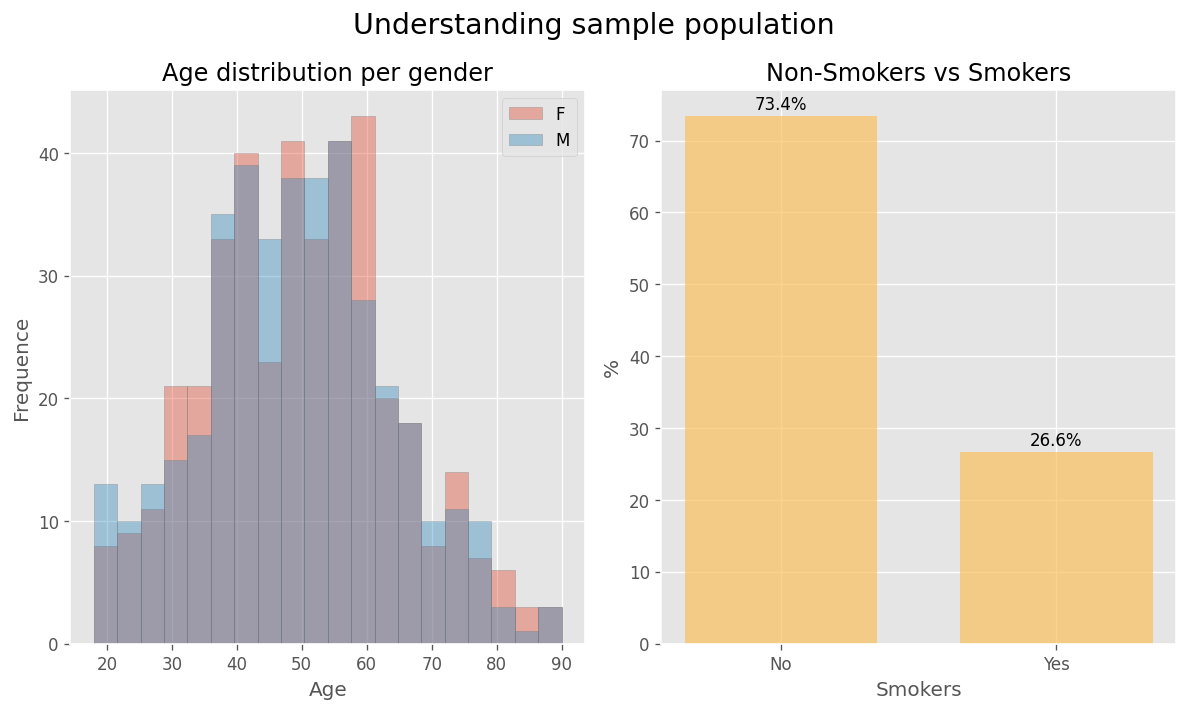

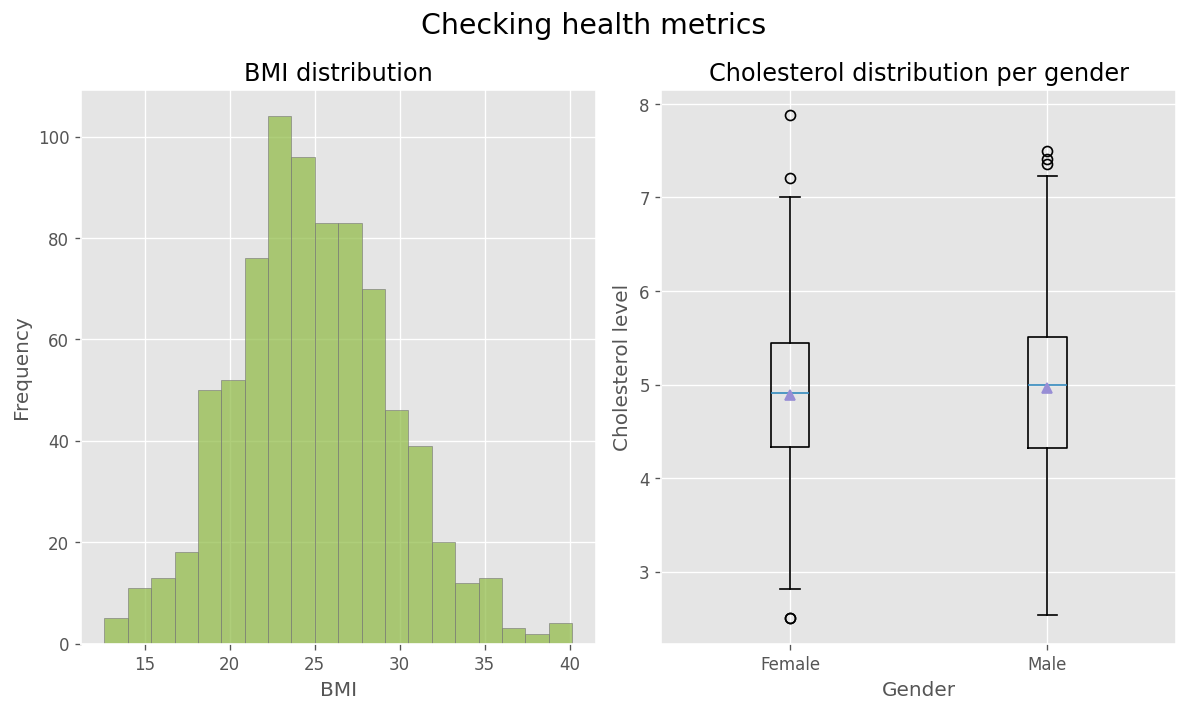

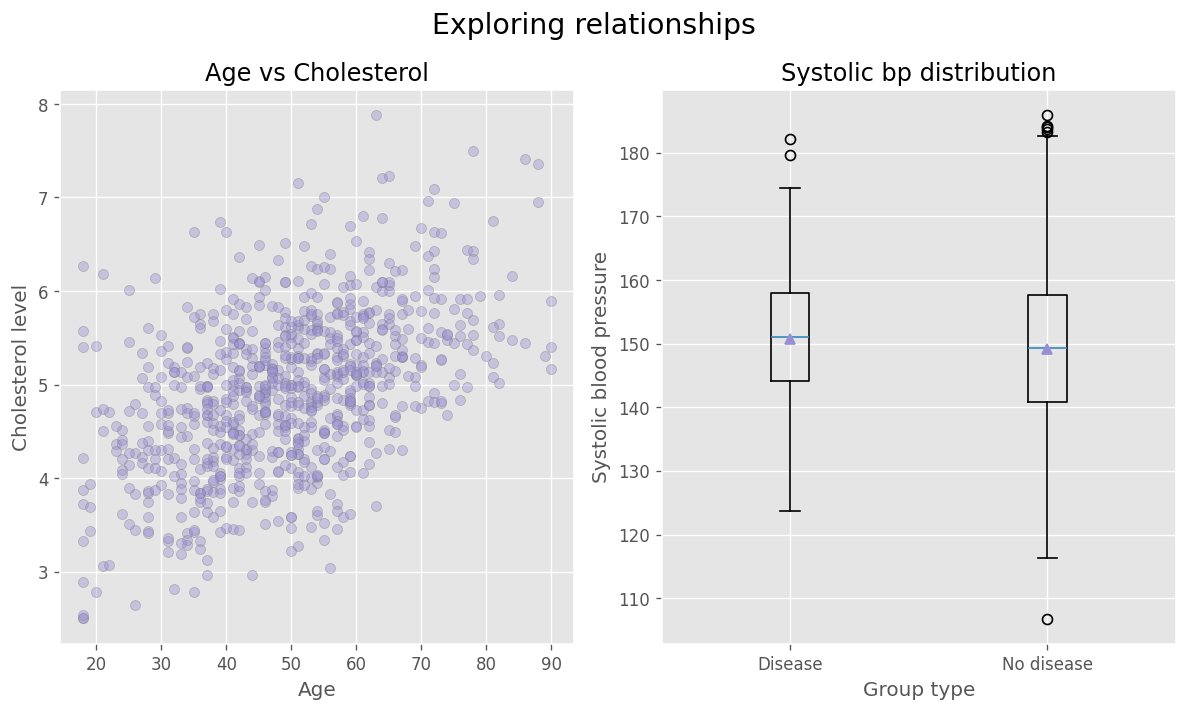

In [20]:
#ggplot palette: ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']

# Histogram: åldersfördelning efter kön
fig1, (ax1, ax2) = plt.subplots(1, 2)
fig1.suptitle("Understanding sample population", fontsize=17)

for s, subset in df.groupby("sex"):
    ax1.hist(subset["age"], edgecolor="#777777", bins=20, label=f"{s}", alpha=0.4)
ax1.set_title("Age distribution per gender")
ax1.set_xlabel("Age")
ax1.set_ylabel("Frequence")
ax1.legend()

# Stapeldiagram: andel rökare
smoker_per = (df["smoker"].value_counts() / df["smoker"].count()) * 100

ax2.bar(smoker_per.index, smoker_per.values, 
        color="#FBC15E", width=0.7, alpha=0.7)
ax2.set_title("Non-Smokers vs Smokers")
ax2.set_xlabel("Smokers")
ax2.set_ylabel("%")
for i, v in enumerate(smoker_per.values):
    ax2.text(i, v + 1, f"{v:.1f}%", ha="center")
plt.tight_layout()
plt.show()

# Histogram: BMIfördelning
fig2, (ax3, ax4) = plt.subplots(1, 2)
fig2.suptitle("Checking health metrics", fontsize=17)

df["bmi"] = df["weight"] / (df["height"] / 100)**2
ax3.hist(df["bmi"], color="#8EBA42", edgecolor="#777777", bins=20, alpha=0.7)
ax3.set_title("BMI distribution")
ax3.set_xlabel("BMI")
ax3.set_ylabel("Frequency")

# Boxplot: cholesterol efter gender
ax4.boxplot([df.loc[df.sex == "F", "cholesterol"], 
           df.loc[df.sex == "M", "cholesterol"]], 
           tick_labels=["Female", "Male"], 
           showmeans=True)
ax4.set_title("Cholesterol distribution per gender")
ax4.set_xlabel("Gender")
ax4.set_ylabel("Cholesterol level")
plt.tight_layout()
plt.show()

# Scatter: age vs cholesterol
fig3, (ax5, ax6) = plt.subplots(1, 2)
fig3.suptitle("Exploring relationships", fontsize=17)

ax5.scatter(df["age"], df["cholesterol"], color="#988ED5", edgecolor="#777777", alpha=0.4)
ax5.set_title("Age vs Cholesterol")
ax5.set_xlabel("Age")
ax5.set_ylabel("Cholesterol level")

# Boxplot: systoliskt blodtryck efter grupp med/utan sjukdom
ax6.boxplot([df.loc[df.disease == 1, "systolic_bp"], 
           df.loc[df.disease == 0, "systolic_bp"]], 
           tick_labels=["Disease", "No disease"], 
           showmeans=True)
ax6.set_title("Systolic bp distribution")
ax6.set_xlabel("Group type")
ax6.set_ylabel("Systolic blood pressure")
plt.tight_layout()
plt.show()

**Insights**:
1. Males and females are fairly evenly represented across the age spectrum and there is a lower prevalence of smokers.
2. Normal weight range with few extremes. Similar cholesterol levels between females and males.
3. Scatter shows that as age increases the colesterol level tends to rise. The systolic blood pressure is similar across groups with or without disease so it doesn't seem like the systolic BP alone can indicate a grouo with or without disease.

## Simulering kopplad till caset

In [21]:
np.random.seed(42) 

# Proportion of people with disease
p_disease = df["disease"].mean()

# Simulation of a 1000 random individuals with same disease proportion
simulated_1000_people = np.random.choice([0, 1], size=1000, p=[1 - p_disease, p_disease])

# Counting proportion of people with desease in simulation
simulated_p_disease = simulated_1000_people.mean()

# Comparing
print(f"Real disease rate: {p_disease * 100:.2f}%.\n"
      f"Simulated disease rate: {simulated_p_disease * 100:.2f}%.")

Real disease rate: 5.88%.
Simulated disease rate: 5.60%.


**Coclusion**:
The difference between the real disease rate and the simulated disease rate is small and falls within the expected variability.

## Konfidensintervall

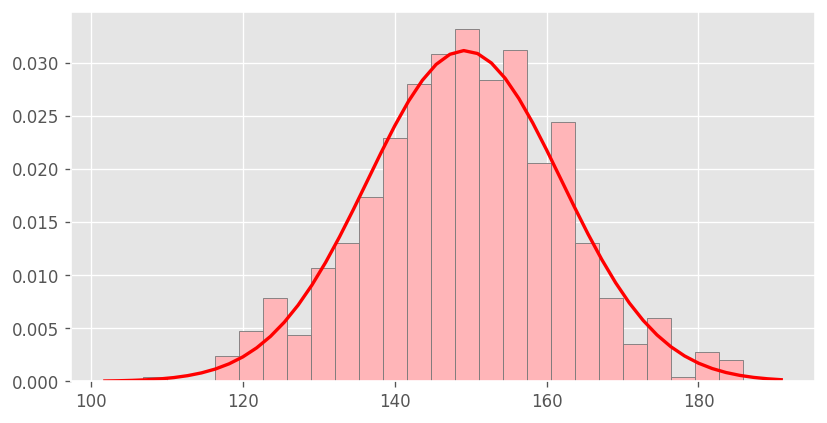

In [22]:
# Is it really normally distributed?
systolic_bp = df["systolic_bp"]
def normal_pdf(x, m, s):
    x = np.asanyarray(x, dtype=float)
    if s <= 0 or not np.isfinite(s):
        raise ValueError("s has to be a positive and finite number")
    
    norm = 1.0 / (s * np.sqrt(2.0 * np.pi))
    z = (x - m) / s
    y = norm * np.exp(-0.5 * z**2)
    return y

x_support = np.linspace(systolic_bp.min()-5, systolic_bp.max()+5)

fix, ax = plt.subplots(figsize=(8,4))
ax.hist(systolic_bp, bins=25, color="#FFB5B8", edgecolor="#777777", density=True)

m = np.mean(systolic_bp)
s = np.std(systolic_bp, ddof=1)

ax.plot(x_support, normal_pdf(x_support, m, s), color="red", lw=2, label="Normal (med vårt medel och std)")
plt.show()

# Yep, it is

In [23]:
systolic_bp = np.array(df["systolic_bp"], dtype=float)
confidence = 0.95
m = np.mean(systolic_bp)
s = np.std(systolic_bp, ddof=1)
n = len(systolic_bp)
z = 1.96

# Normal approximation
margin_error = z * (s / np.sqrt(n))
lo = m - margin_error
hi = m + margin_error

# Bootstrap
B = 3000
boot_means = np.empty(B)
for b in range(B):
    boot_sample = np.random.choice(systolic_bp, size=n, replace=True)
    boot_means[b] = np.mean(boot_sample)

alpha = (1 - confidence) / 2
bmean = np.mean(boot_means)
blo, bhi = np.percentile(boot_means, [100*alpha, 100*(1 - alpha)])

print(f"Summary:\n"
      f"Point of estimate: {m:.2f}\n"
      f"Standard deviation: {s:.2f}\n"
      f"\n"
      f"The normal approximation result reads:\n"
      f"Lower 95% CI bound: {lo:.2f}\n"
      f"Upper 95% CI bound: {hi:.2f}\n"
      f"\n"
      f"The bootstrap result reads:\n"
      f"Statistic mean: {bmean:.2f}\n"
      f"Lower 95% CI bound: {blo:.2f}\n"
      f"Upper 95% CI bound: {bhi:.2f}")

Summary:
Point of estimate: 149.18
Standard deviation: 12.79

The normal approximation result reads:
Lower 95% CI bound: 148.29
Upper 95% CI bound: 150.07

The bootstrap result reads:
Statistic mean: 149.19
Lower 95% CI bound: 148.34
Upper 95% CI bound: 150.09


Conclusion:
Both the methods gave a very similar result.

**Hypotesprövning**

- Testa hypotesen: ”Rökare har högre medel-blodtryck än icke-rökare.”
- Använd en av metoderna vi gått igenom (t.ex. bootstrap eller enkel t-test-funktion).
- Förklara kort resultatet i en markdown-ruta.

In [ ]:
#H0: Smokers and non smokers have the same blood pressure
#H1: Smokers have a higher blood pressure than non smokers
smokers = df.loc[df["smoker"] == "Yes", "systolic_bp"]
non_smokers = df.loc[df["smoker"] == "No", "systolic_bp"]

# 2 indipendent samples, one-sided test (right tail)
# T-test: is the difference between the two sample means large enough that it’s unlikely to have happened by chance?
t_stat, p_value = stats.ttest_ind(smokers, non_smokers, equal_var=False, alternative="greater")
smokers_mean, non_smokers_mean = smokers.mean(), non_smokers.mean()
diff_means = smokers_mean - non_smokers_mean

summary_txt = f"""
I tested whether smokers have higher mean systolic blood pressure than non-smokers. Blood pressure is continuous and the two groups are independent, so I chose a two sample samples t-test, measuring one tail as we are measuring if the smokers blood pressure is higher. using Welch+s (equal_var=False) because the 2 samples have different sizes
Smokers mean: {smokers_mean:.3f}
Non smokers mean: {non_smokers_mean:.3f}
Difference between the means: {diff_means:.3f}

The test produced a t-statistic of {t_stat:.3f} and a p-value of {p_value:.3f}.
Given that the p-value is greater than 0.05, we fail to reject the H0 as there isn't strong evidence that smoker's blood pressure is higher
fail to reject H0
"""
print(summary_txt)


I tested whether smokers have higher mean systolic blood pressure than non-smokers. Blood pressure is continuous and the two groups are independent, so I chose a two sample samples t-test, measuring one tail as we are measuring if the smokers blood pressure is higher.
Smokers mean: 149.525
Non smokers mean: 149.053
Difference between the means: 0.472

The test produced a t-statistic of 0.450 and a p-value of 0.326.
Given that the p-value is greater than 0.05, we fail to reject the H0 as there isn't strong evidence that smoker's blood pressure is higher



## Simulation of statistical power - power analysis

Power: probability of correctly rejecting H0 when H1 is true.

to test if the result of the t test is correct, I can repeat it (simulating several synthetic tests). If the results are similar or equal to my previous one, I can confirm it.

power analysis: determines what sample size will ensure a high probability that we correctly rejects the Null Hip

In [25]:
# plotting the distribution of blood pressure of the 2 groups to see if they have a different distribution

In [26]:
# Testing statistical power of previous test

alpha = 0.05
n_smokers, n_non_smokers = len(smokers), len(non_smokers)
smokers_mean, non_smokers_mean = smokers.mean(), non_smokers.mean()

sd_smokers, sd_non_smokers = smokers.std(), non_smokers.std()
pooled_sd = np.sqrt(((n_smokers - 1) * sd_smokers**2 + (n_non_smokers - 1) * sd_non_smokers**2) / (n_smokers + n_non_smokers - 2))

effect_size = (smokers_mean - non_smokers_mean) / pooled_sd

solver = TTestIndPower()
theoretical_power = solver.solve_power(effect_size=effect_size, nobs1=n_smokers, ratio=n_non_smokers / n_smokers, alpha=alpha, alternative="larger")
print(effect_size, theoretical_power)


# 
def simulate_ttest_power(smokers_mean, non_smokers_mean, sd_smokers, sd_non_smokers, n_smokers, n_non_smokers, alpha=0.05, n_sim=5000):
    rejections = 0
    for _ in range(n_sim):
        smokers = np.random.normal(smokers_mean, sd_smokers, n_smokers)
        nonsmokers = np.random.normal(non_smokers_mean, sd_non_smokers, n_non_smokers)
        
        t_stat_sim, p_val = stats.ttest_ind(smokers, nonsmokers, equal_var=False, alternative="greater")
        
        if p_val < alpha:
            rejections += 1

    return rejections / n_sim

sim_power = simulate_ttest_power(smokers_mean, non_smokers_mean, 
                                 sd_smokers, sd_non_smokers, 
                                 n_smokers, n_non_smokers, 
                                 alpha=alpha, n_sim=20000)
print(sim_power)

summary_power = f"""
The result shows that there is very little power. This is due to the 
the observed mean difference (≈ 0.47 mmHg) was very small relative to within-group variability (SD ≈ 13 mmHg).

The resulting power (~0.1) indicates that even if this small effect were real, the test would rarely detect it.
This suggests that the null result reflects a true lack of meaningful difference, rather than a methodological flaw or incorrect test choice.

In practice, the test confirms that smoking status is not associated with a clinically or statistically significant change in blood pressure in this sample.
"""

0.03686824466352876 0.11814043698698173
0.1108


In [29]:
#Given my sample sizes (213 vs 587) and α = 0.05, how big a mean difference would I need to reach 80% power?

alpha = 0.05
power_target = 0.8
ratio = n_non_smokers / n_smokers

# Use the average SD (pooled from your data)
s_pooled = np.sqrt(((n_smokers - 1) * sd_smokers**2 + (n_non_smokers - 1) * sd_non_smokers**2) / (n_smokers + n_non_smokers - 2))

# Initialize solver
solver = TTestIndPower()

# Solve for Cohen's d needed to reach 80% power
required_d = solver.solve_power(effect_size=None, nobs1=n_smokers, ratio=ratio,
                                alpha=alpha, power=power_target, alternative="larger")

# Convert Cohen's d back into a mean difference
required_mean_diff = required_d * s_pooled

print(s_pooled, required_d, required_mean_diff)

"""Based on my sample sizes (n = 213 smokers, n = 587 non-smokers), a one-sided independent samples t-test with alpha = 0.05 would require a mean difference of approximately 2.55 mmHg (Cohen’s d ≈ 0.20) to achieve 80% statistical power.
The observed difference in my data (≈ 0.47 mmHg) is much smaller than this threshold, resulting in low test power (~11%).
Therefore, the non-significant result does not reflect a poor test choice, but rather that any true difference in systolic blood pressure between smokers and non-smokers is very small and practically negligible."""

12.799670089188028 0.19906354729074596 2.547947732105028


'Based on my sample sizes (n = 213 smokers, n = 587 non-smokers), a one-sided independent samples t-test with alpha = 0.05 would require a mean difference of approximately 2.55 mmHg (Cohen’s d ≈ 0.20) to achieve 80% statistical power.\nThe observed difference in my data (≈ 0.47 mmHg) is much smaller than this threshold, resulting in low test power (~11%).\nTherefore, the non-significant result does not reflect a poor test choice, but rather that any true difference in systolic blood pressure between smokers and non-smokers is very small and practically negligible.'

### **För VG ska du även göra:**

- Gör en simulering för att undersöka **hur säkert ditt hypotes­test är** (t.ex. hur ofta testet hittar en skillnad när den finns → power).
- Motivera dina metodval i markdown och hänvisa till dokumentation eller annan källa.